In [4]:
!pip install -Uqq fastbook 
import fastbook
fastbook.setup_book()

In [5]:
# check for latest release https://pypi.org/project/timm/0.6.2.dev0/#history
!pip install -Uqq timm==0.6.2.dev0

In [24]:
import torch
import fastai
from fastbook import *
import timm
print(f' Fastai {fastai.__version__}\nPytorch {torch.__version__}\n   Timm {timm.__version__}')
try:
    free, total = torch.cuda.mem_get_info() 
    print(f'    GPU {torch.cuda.get_device_name(0)} ({total//1024**2} MB)')
except: print("No GPU detected")

 Fastai 2.6.3
Pytorch 1.10.0
   Timm 0.6.2.dev0
    GPU Quadro P5000 (16278 MB)


## CNN Interpretation with CAM 
Class activation maps

In [31]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): 
    return x[0].isupper()

# data loader
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224), bs=64)

In [32]:
# resnet learner
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.140198,0.031265,0.009472,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.047088,0.012306,0.004736,00:23


Using `convnext` model from [timm](https://github.com/rwightman/pytorch-image-models)

In [140]:
# convnext learner
learn = vision_learner(dls, arch="convnext_small_in22k", metrics=error_rate).to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.082633,0.002782,0.000677,05:19


epoch,train_loss,valid_loss,error_rate,time
0,0.011867,0.003864,0.000677,05:29


In [5]:
# vit learner
learn = vision_learner(dls, arch="vit_tiny_patch16_224", metrics=error_rate).to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.221755,0.018691,0.004736,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.050843,0.013731,0.004060,00:22


## Get example image

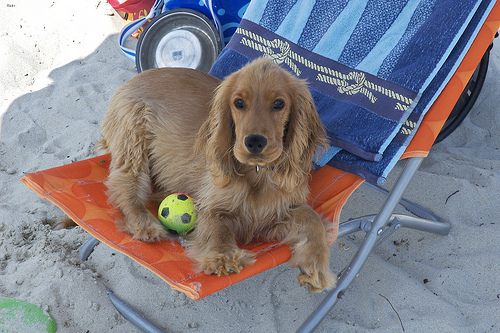

In [33]:
# picture from dataset
n = 4451
img = PILImage.create((path).ls()[n])
x, = first(dls.test_dl([img]))         # pass through pre-processing steps
img

> For CAM we want to store the activations of the last convolutional layer. We put our hook function in a class so it has a state that we can access later, and just store a copy of the output:

In [34]:
# add hook to final activation layer
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [35]:
with torch.no_grad(): output = learn.model.eval()(x)

act = hook_output.stored[0]

In [36]:
# double check prediction (dog)
F.softmax(output, dim=-1)

TensorBase([[9.9999e-01, 5.1600e-06]], device='cuda:0')

In [37]:
# we know 0 (for False) is "dog" aka not-cat
dls.vocab

[False, True]

Our model is very confident it is not a cat.

In [38]:
learn.model[1][-1].weight.shape

torch.Size([2, 512])

In [39]:
x.shape

torch.Size([1, 3, 224, 224])

In [40]:
cam_map= torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

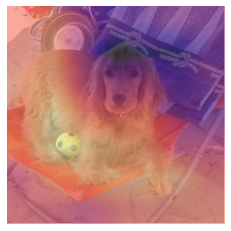

In [41]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
# Once you're done with your hook, you should remove it as otherwise it might leak some memory:
hook.remove()

> That's why it's usually a good idea to have the Hook class be a context manager, registering the hook when you enter it and removing it when you exit.

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
# we can safely use it this way:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

> This method is useful, but only works for the last layer. *Gradient CAM* is a variant that addresses this problem.

## Gradient CAM
> The method we just saw only lets us compute a heatmap with the last activations, since once we have our features, we have to multiply them by the last weight matrix. This won't work for inner layers in the network. A variant introduced in the paper ["Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1611.07450) in 2016 uses the gradients of the final activation for the desired class.

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

> The weights for our Grad-CAM are given by the average of our gradients across the feature map. Then it's exactly the same as before:

In [ ]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

> The novelty with Grad-CAM is that we can use it on any layer. For example, here we use it on the output of the second-to-last ResNet group:

In [ ]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

In [ ]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');